In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

## Ⅰ. 가중치를 모두 같은 값으로 초기화하면?

* 순전파때 다음 layer에 모두 같은 값이 전달됨 => 역전파때 가중치가 모두 똑같이 갱신되어 여전히 같은 값이 됨
* 따라서 초기값을 무작위로 설정해 대칭성을 무너트려야 함

In [2]:
from common.multi_layer_net import MultiLayerNet
from dataset.mnist import load_mnist
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 5000
batch_size = 100

network = MultiLayerNet(input_size=784, hidden_size_list=[100], output_size=10)
optimizer = SGD()
for weight in network.params.values():
    weight[:] = np.random.rand()

bf = network.params['W2'].copy()

for i in range(iters_num):
    batch_mask = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if (i+1) % 1000 == 0:
        print( "===========" + "iteration:" + str(i+1) + "===========")
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        print(f'iteration {i+1:02}/{iters_num}\t train accuracy : {train_acc:.4f}\t test accuracy : {test_acc:.4f}')

with np.printoptions(precision=3, threshold=5):
    print('\nW2 before Training:')
    print(bf)
    print('\nW2 after Training:')
    print(network.params['W2'])

===========iteration:1000===========
iteration 1000/5000	 train accuracy : 0.1446	 test accuracy : 0.1463
===========iteration:2000===========
iteration 2000/5000	 train accuracy : 0.1769	 test accuracy : 0.1802
===========iteration:3000===========
iteration 3000/5000	 train accuracy : 0.1550	 test accuracy : 0.1583
===========iteration:4000===========
iteration 4000/5000	 train accuracy : 0.1878	 test accuracy : 0.1882
===========iteration:5000===========
iteration 5000/5000	 train accuracy : 0.1845	 test accuracy : 0.1844

W2 before Training:
[[0.611 0.611 0.611 ... 0.611 0.611 0.611]
 [0.611 0.611 0.611 ... 0.611 0.611 0.611]
 [0.611 0.611 0.611 ... 0.611 0.611 0.611]
 ...
 [0.611 0.611 0.611 ... 0.611 0.611 0.611]
 [0.611 0.611 0.611 ... 0.611 0.611 0.611]
 [0.611 0.611 0.611 ... 0.611 0.611 0.611]]

W2 after Training:
[[0.612 0.601 0.621 ... 0.611 0.605 0.61 ]
 [0.612 0.601 0.621 ... 0.611 0.605 0.61 ]
 [0.612 0.601 0.621 ... 0.611 0.605 0.61 ]
 ...
 [0.612 0.601 0.621 ... 0.611 0

## Ⅱ. std에 따른 은닉층의 활성화값 분포

In [3]:
from common.functions import sigmoid, relu

def activations_hist(std, activation_function, n_layers=5, n_nodes=100, batch_size=1000, lim=(0,1), ylim=None):

    x = np.random.randn(batch_size, n_nodes)
    activations = {}

    for i in range(n_layers):
        w = std * np.random.randn(n_nodes, n_nodes)
        activations[i] = x = activation_function(np.dot(x, w))

    fig, axes = plt.subplots(1, n_layers, sharey=True, figsize=(15, 5))
    fig.suptitle(f'Weight Std : {std}', fontsize=16)
    if ylim is not None:
        axes[0].set_ylim(ylim)
    for i in activations:
        axes[i].set_title(f'{i+1}-layer')
        axes[i].hist(activations[i].flatten(), 30, range=lim)
    plt.show()

### 1. std가 너무 큰 경우

* 활성화값들이 0과 1에 치우쳐짐 => gradient vanishing 문제

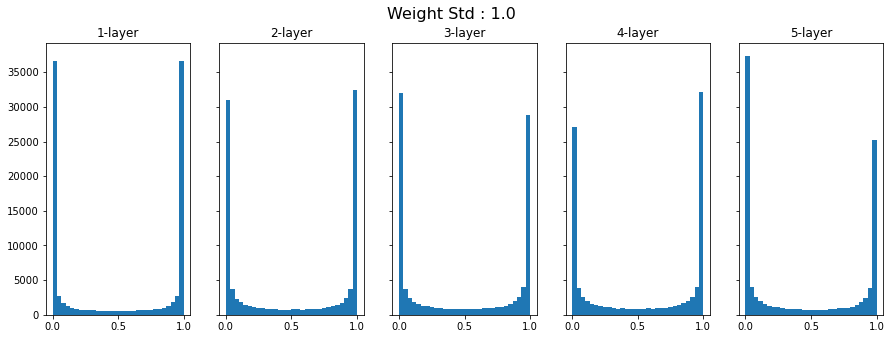

In [4]:
activations_hist(1.0, sigmoid)

### 2. std가 너무 작은 경우

* 활성화값들이 0.5에 몰려있음 => 표현력이 제한됨

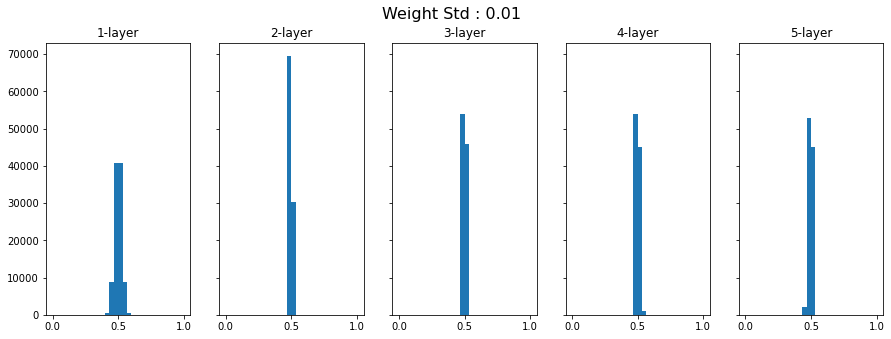

In [5]:
activations_hist(0.01, sigmoid)

## Ⅲ. Xavier Initialization

* 활성화함수가 선형인 것을 전제 => sigmoid / tanh 일때 적절
$$
W \sim N(\mu = 0,\,\sigma = \sqrt{\frac{1}{n_{in}}})
$$

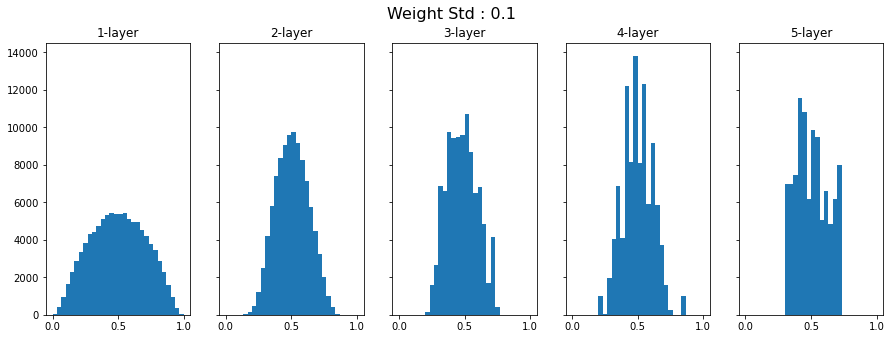

In [6]:
activations_hist(np.sqrt(1/100), sigmoid)

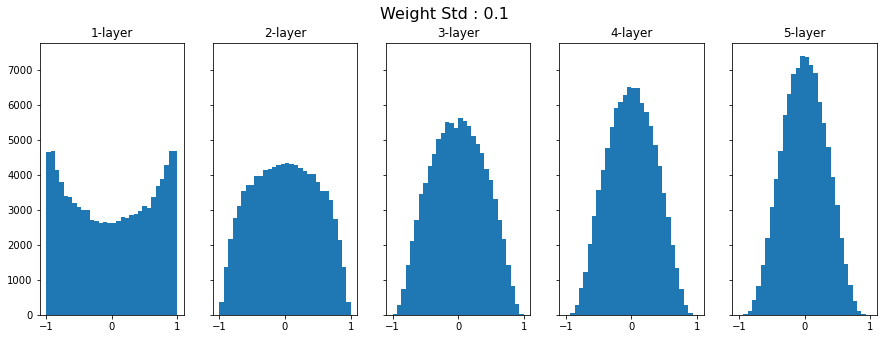

In [7]:
activations_hist(np.sqrt(1/100), np.tanh, lim=(-1,1))

## Ⅲ. He Initialization

* 활성화 함수로 ReLU를 쓸 경우에 적합
$$
W \sim N(\mu = 0,\,\sigma = \sqrt{\frac{2}{n_{in}}})
$$

### 1. ReLU with Xavier Initialization

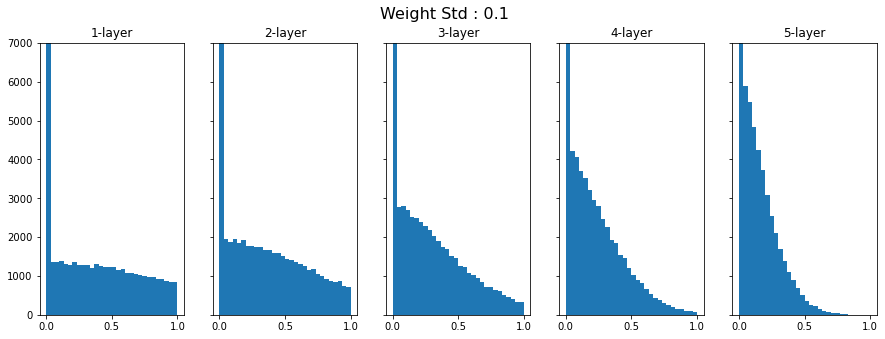

In [8]:
activations_hist(np.sqrt(1/100), relu, ylim= [0,7000])

### 2. ReLU with He Initialization

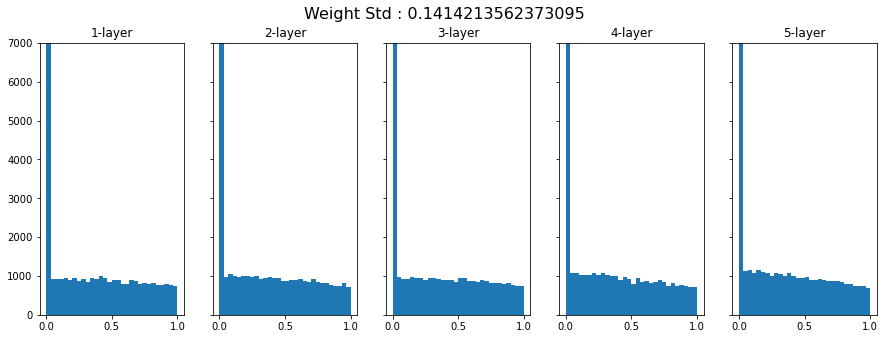

In [9]:
activations_hist(np.sqrt(2/100), relu, lim=(0,1), ylim= [0,7000])

## Ⅳ. MNIST 데이터셋으로 비교

===========iteration:500===========
std=0.01:2.300360584358229
Xavier:0.799777696451815
He:0.3330404351722455
===========iteration:1000===========
std=0.01:2.307808391036847
Xavier:0.34059758556822134
He:0.23075515635041116
===========iteration:1500===========
std=0.01:2.301118215623651
Xavier:0.23910483818041092
He:0.17317899255917413
===========iteration:2000===========
std=0.01:2.3064303085957434
Xavier:0.25312593637087033
He:0.17484638220149235


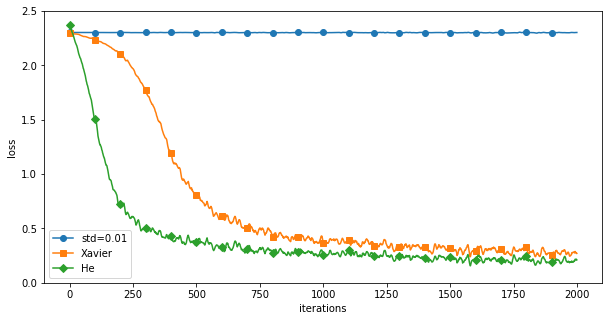

In [10]:
from common.util import smooth_curve

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch, t_batch = x_train[batch_mask], t_train[batch_mask]
    
    for key in weight_init_types:
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if (i+1) % 500 == 0:
        print("===========" + "iteration:" + str(i+1) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
plt.figure(figsize=(10,5))
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()